(ch6:spectral)=
# Spectral embedding methods

Now that we know some of the basics of *why* we embed networks, it's time to learn some about the *spectral embedding* {cite:t}`spectraltutorial`. You'll see spectral embedding and variations on it repeatedly, both throughout this section and when you get into applications, so it's worth taking the time to understand spectral embedding deeply. If you're familiar with Principal Component Analysis (PCA) {cite:p}`Jolliffe2016Apr`, this method has a lot of similarities. If you want to learn a bit about PCA, we'd recommend you check out the Geron book {cite:p}`Geron2017Mar`. We'll need to get into a bit of linear algebra to understand how it works.

Remember that the basic idea behind any network embedding method is to take the network and put it into Euclidean space - meaning, a nice data table with rows as observations and columns as features (or dimensions), which you can then plot on an x-y axis. In this section, you'll see the linear algebra-centric approach that spectral embedding uses to do this.

Spectral methods are based on a bit of linear algebra, but hopefully a small enough amount to still be understandable. The overall idea has to do with taking a function of the adjacency matrix, and finding a simpler representation of it. This simpler representation is computed by identifying the singular values and vectors of a function of the adjacency matrix, which is a process known as the *singular value decomposition*, covered in {cite:p}`Axler` or {cite:p}`Trefethen1997`. In essence, the singular values and singular vectors allow you to take a matrix, and represent it as a sum of "simple" matrices (in linear algebra speak, they are *rank-1* matrices). For our purposes, what this does is it makes patterns in the adjacency matrix "jump out" at us. Remember the example we gave back in {numref}`ch5:sbm:modularity` at the bottom? To recap, when a sample of an SBM was ordered by community label, the modularity, and hence the communities of the nodes, were apparent. But, when we shuffled around the adjacency matrix, this nice pattern disappeared. While the adjacency matrix itself won't have this nice pattern anymore, simple ways of reorganizing the singular values and vectors, called the *spectrum* of the function of the adjacency matrix that you pick, just might! Because we're finding a structure that is "hidden" in the adjacency matrix and uncovered by looking at the matrix's *spectrum*, we'll call this procedure a spectral embedding.

```{admonition} Singular Values and Singular Vectors
If you don't know what singular values and singular vectors are, don't worry about it. You can think of them as a generalization of eigenvalues/vectors (it's also ok if you don't know what those are): all matrices have singular values and singular vectors, but not all matrices have eigenvalues and eigenvectors. In the case of square, symmetric matrices with positive eigenvalues, a singular value decomposition is *also* an eigendecomposition of the matrix.

If you want some more background information on the eigenvalue or singular value decompositions, there are some decent explanations in numerous undergraduate linear algebra textbooks, of which the books {cite:p}`Trefethen1997` or {cite:p}`Axler` are our favorite. The singular vectors an important set of vectors associated with matrices with a bunch of interesting properties. A lot of linear algebra is built around exploring those properties.
```

You can see visually how spectral embedding works below. We start with a 20-node Stochastic Block Model with two communities, and then found its singular values and vectors. It turns out that because there are only two communities, only the first two singular vectors contain information -- the rest are just noise! (you can see this if you look carefully at the first two columns of the singular vector matrix). So, you took these two columns and scaled them by the first two singular vectors of the singular value matrix $D$. The final embedding is that scaled matrix, and the plot you see takes the rows of that matrix and puts them into Euclidean space (an x-y axis) as points. This matrix is called the *estimated latent position matrix*, and the embeddings for the nodes are called the *estimated latent positions*. Underneath the figure is a list that explains how the algorithm works, step-by-step.

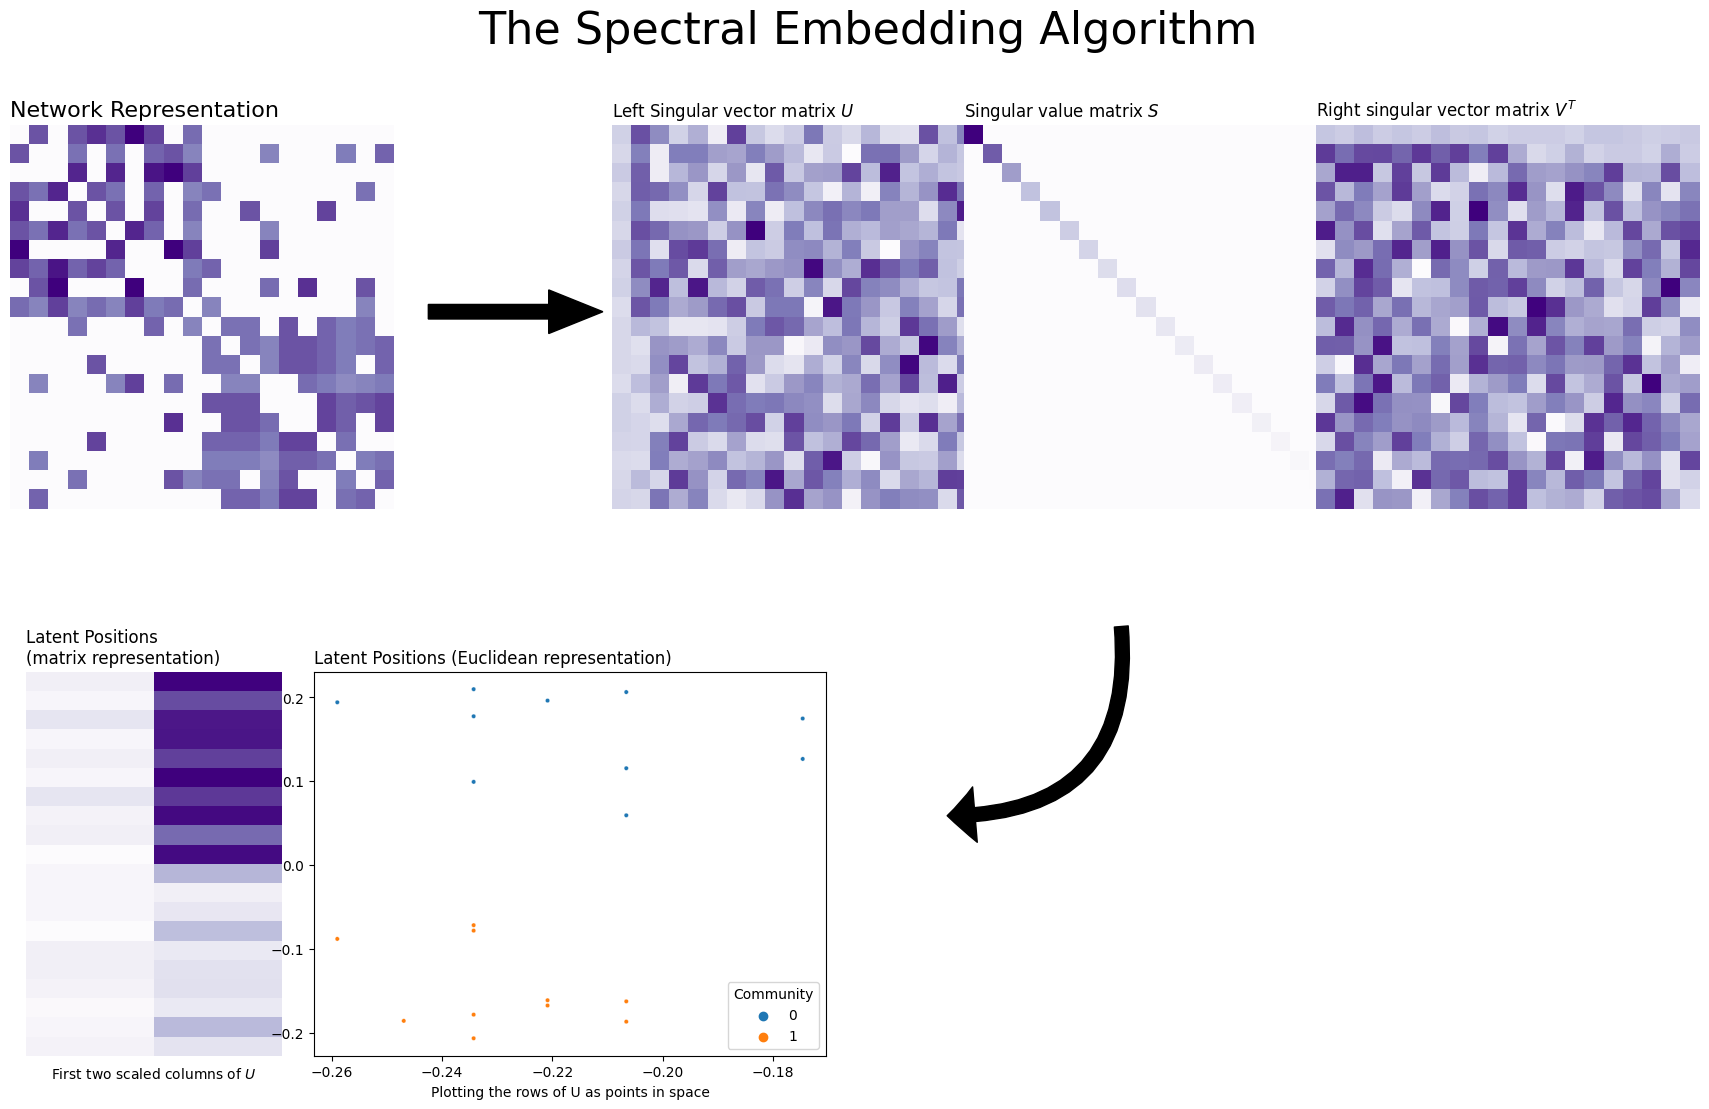

In [2]:
from graspologic.simulations import sbm
from graphbook_code import heatmap, cmaps, plot_latents
from graspologic.utils import to_laplacian
from scipy.linalg import svd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def rm_ticks(ax, x=False, y=False, **kwargs):
    if x is not None:
        ax.axes.xaxis.set_visible(x)
    if y is not None:
        ax.axes.yaxis.set_visible(y)
    sns.despine(ax=ax, **kwargs)

# Make network
B = np.array([[0.8, 0.1], 
              [0.1, 0.8]])
n = [10, 10]
A, labels = sbm(n=n, p=B, return_labels=True)
L = to_laplacian(A)
U, E, Ut = svd(L)
n_components = 2
Uc = U[:, :n_components]
Ec = E[:n_components]
latents = Uc @ np.diag(Ec)
    
fig = plt.figure();

ax = fig.add_axes([.06, -.06, .8, .8]) 
ax = heatmap(L, ax=ax, cbar=False)
ax.set_title("Network Representation", loc="left", fontsize=16)


# add arrow
arrow_ax = fig.add_axes([.8, .3, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# add joint matrix
ax = fig.add_axes([1, -.02*3, .8, .8])
ax = heatmap(U, ax=ax, cbar=False)
ax.set_title("Left Singular vector matrix $U$", loc="left")

ax = fig.add_axes([1.55, -.06, .8, .8])
ax = heatmap(np.diag(E), ax=ax, cbar=False)
ax.set_title("Singular value matrix $S$", loc="left")

ax = fig.add_axes([2.1, -.06, .8, .8])
ax = heatmap(Ut, ax=ax, cbar=False)
ax.set_title("Right singular vector matrix $V^T$", loc="left")
    
# add second arrow
arrow_ax = fig.add_axes([1.5, -1.2, 1.2, 1])
rm_ticks(arrow_ax, left=True, bottom=True)
style = "Simple, tail_width=10, head_width=40, head_length=20"
kw = dict(arrowstyle=style, color="k", alpha=1)
text_arrow = patches.FancyArrowPatch((0.33, .9), (.1, .5), connectionstyle="arc3, rad=-.55", **kw)
arrow_ax.add_patch(text_arrow)


# Embedding
ax = fig.add_axes([.185, -1.2, .4, .8])
cmap = cmaps["sequential"]
ax = sns.heatmap(latents, cmap=cmap, 
            ax=ax, cbar=False, xticklabels=False, yticklabels=False)
ax.set_title("Latent Positions \n(matrix representation)", loc="left")
ax.set_xlabel("First two scaled columns of $U$")

ax = fig.add_axes([.185+.45, -1.2, .8, .8])
plot_latents(latents, ax=ax, labels=labels)
ax.set_title("Latent Positions (Euclidean representation)", loc="left")
ax.set_xlabel("Plotting the rows of U as points in space")

fig.suptitle("The Spectral Embedding Algorithm", fontsize=32, x=1.5);

```{admonition} The Spectral Embedding Algorithm
1. Take a network's adjacency matrix. Optionally take its Laplacian as a network representation.
2. Decompose the matrix into its singular values and vectors.
3. Remove every column of the left singular vector matrix except for the first $k$ vectors, corresponding to the $k$ largest singular values.
4. Scale the $k$ remaining columns by the square root of the corresponding singular values to create the embedding.
5. The rows of this embedding matrix are the locations in latent space for the nodes of the network (called the estimated latent positions). The embedding matrix is an estimate of the latent position matrix, from {ref}`ch5:rdpg`.
```

We need to dive into a few specifics to understand spectral embedding better. You need to figure out how to find your network's singular vectors, for instance, and you also need to understand why those singular vectors can be used to form a representation of your network. To do this, we'll explore a few concepts from linear algebra, and we'll see how understanding these concepts connects to understanding spectral embedding.

To accomplish this, let's start by generating a simple network.

## A simple network

Say you have the simple network from our example back in {ref}`ch5:sbm`: you have a sample of a network from from two schools, where you had $100$ nodes representing the students. Each student attended one of the two schools, with the first $50$ students attending school $1$ and the second $50$ students attending school $2$. The block matrix is:
\begin{align*}
    B &= \begin{bmatrix}
        0.6 & 0.2 \\
        0.2 & 0.4
    \end{bmatrix}
\end{align*}
Or that if two students both attend school $1$ or both attend school $2$, their probabilities of being friends are $0.6$ and $0.4$ respectively, whereas if the students attend different schools, their probability of being friends is $0.2$. Let's generate a sample from this network:

In [3]:
from graspologic.simulations import sbm

ns = [50, 50]
B = [[0.6, 0.2], [0.2, 0.4]]

A, zs = sbm(ns, B, directed=False, loops=False, return_labels=True)
zs = zs + 1  # to make 1s and 2s instead of 0s and 1s

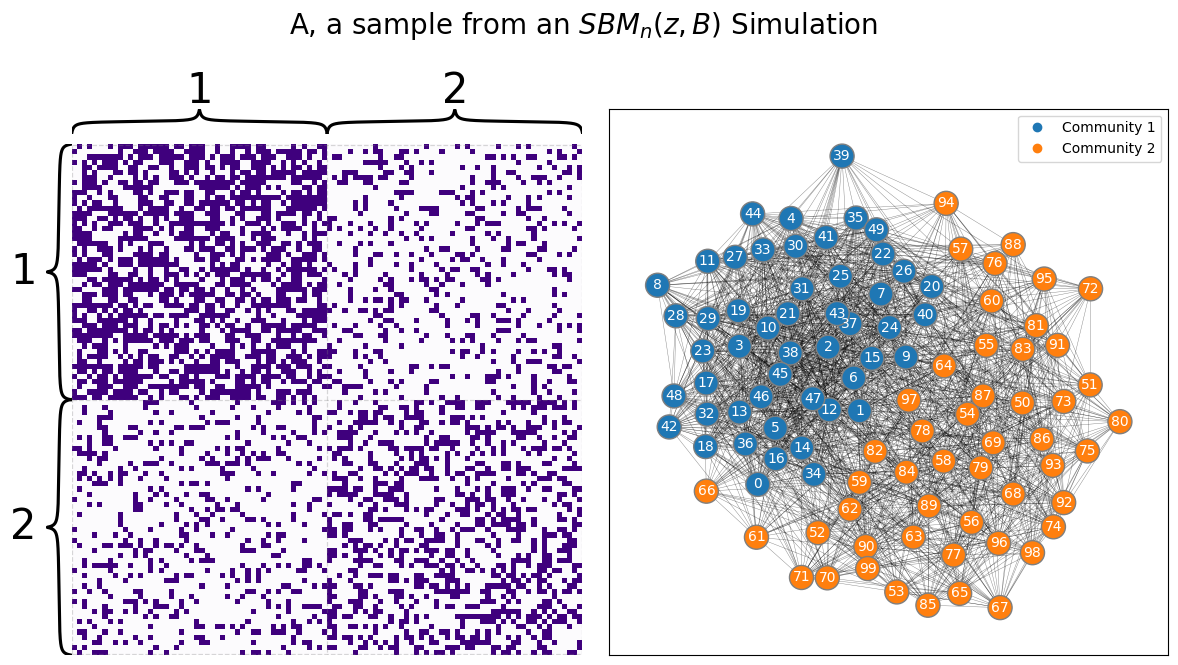

In [4]:
from graphbook_code import draw_multiplot
draw_multiplot(A, labels=zs, title="A, a sample from an $SBM_n(z, B)$ Simulation");

## The Laplacian matrix

With spectral embedding, you'll either find the singular vectors of the Laplacian or the singular vectors of the Adjacency Matrix itself. Since you already have the adjacency matrix, let's take the Laplacian just to see what that looks like.

Remember from chapter four that there are a few different types of Laplacian matrices. By default, for undirected networks, Graspologic uses the `DAD` Laplacian $L^{DAD} = D^{-1/2} A D^{-1/2}$, where $D$ is the degree matrix. Remember that the degree matrix has the degree, or number of edges, of each node along the diagonals, which you learned about in {numref}`ch4:matrix-rep`. For brevity for the remainder of this section, we'll just use the term $L$ in place of $L^{DAD}$. There is no restriction for spectral embedding to using the `DAD`, regularized, or normalized Laplacian. It works with any of them, with an important caveat we'll point out later. 

Let's take a look at the Laplacian for the diagonal augmentation of the adjacency matrix $A$, and was discussed in {numref}`ch4:prop-net`:

In [5]:
from graspologic.utils import to_laplacian

n = np.sum(ns)
L = to_laplacian(A)

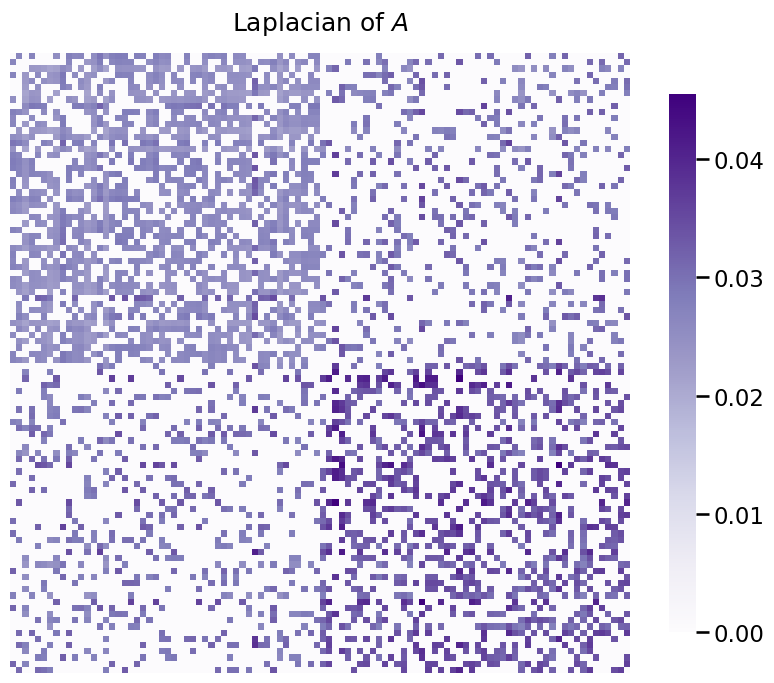

In [6]:
heatmap(L, title="Laplacian of $A$");

(ch6:spectral:svd)=
## Obtaining the *spectrum* of the Laplacian

The next step in the spectral embedding is, well, to obtain the *spectrum* of the Laplacian. The *spectrum* of a matrix refers to its eigenvalues and eigenvectors, or more generally, its *singular values* and *singular vectors*. For now, all you need to know is that the singular values and vectors allow you to take a matrix, and break it apart into *simpler parts*. This procedure is generally referred to as a *matrix decomposition* or factorization, which means taking a matrix and breaking it into a product of other matrices. In particular, in the spectral embedding, what you do is compute the *singular value decomposition* (`svd`) of the Laplacian matrix, which is a set matrices $U$, $\Sigma$, and $V$, where:

\begin{align*}
    L &= U\Sigma V^\top
\end{align*}

These matrices have extremely unique properties, but the only thing you will need to know for now are the following few facts for the `svd` of a Laplacian for a simple network with $n$ nodes:
1. The left singular vectors of the matrix $U$ are the columns $\vec u_i$, where:
\begin{align*}
    U &= \begin{bmatrix}
        \uparrow & & \uparrow \\
        \vec u_1 & ... & \vec u_n \\
        \downarrow & & \downarrow
    \end{bmatrix}
\end{align*}
2. The matrix $\Sigma$ is diagonal, or all of its non-diagonal entries are $0$, and its diagonal entries are called the singular values $\sigma_i$:
\begin{align*}
    \Sigma &= \begin{bmatrix}
    \sigma_1 & 0 & ... & 0 \\
    0 & \sigma_2 & \ddots & \vdots \\
    \vdots & \ddots & \ddots & 0 \\
    0 & ... & 0 & \sigma_n
    \end{bmatrix}
\end{align*}
3. The right singular vectors of the matrix $V$ are the columns $\vec v_i$, where:
\begin{align*}
    V &= \begin{bmatrix}
        \uparrow & & \uparrow \\
        \vec v_1 & ... & \vec v_n \\
        \downarrow & & \downarrow
    \end{bmatrix}
\end{align*}

The indices $i$ of a given set of singular vectors with their corresponding singular value, the triple $(\vec u_i, \sigma_i, \vec v_i)$, will correspond to the dimensionality that a particular triple is associated with. You can compute the `svd` using any numerical linear algebra package, such as `numpy`:

In [7]:
from numpy.linalg import svd
U, s, Vt = svd(L)

Next up, we need to start thinking about the space that we are embedding into. What we are doing is attempting to find a *latent* space in which we can embed the Laplacian. This embedding of the Laplacian is called a *latent representation* of the Laplacian because the representation is *hidden* when you first compute the Laplacian. Next, let's think about how this latent representation is comprised. 

(ch6:spectral:scree)=
### Looking at the singular values of $L$ with the scree plot

The first place to start whenever you need a singular value decomposition of a matrix, such as when you compute any spectral embedding, is something called a scree plot. The **scree plot** just plots the singular values (the diagonal entries of $\Sigma$) by their indices: the first (biggest) singular value is in the beginning, and the last (smallest) singular value is at the end. The indices for the singular values index the *latent dimensions* of the latent representation for the Laplacian. Let's take a look at what this looks like:

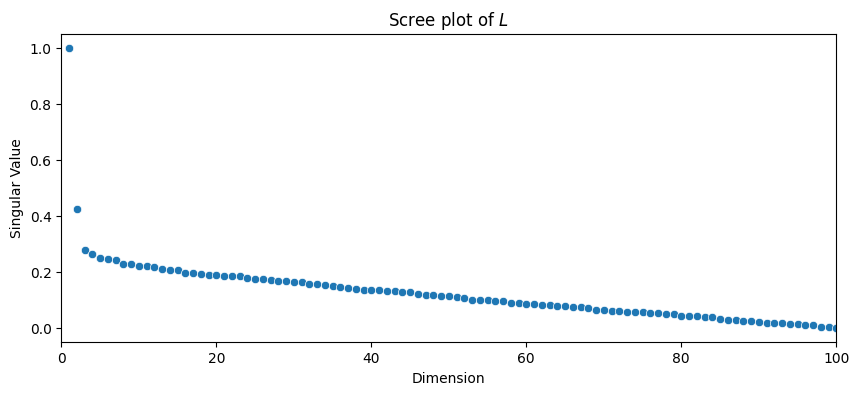

In [8]:
from pandas import DataFrame

def plot_scree(svs, title="", d=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(10, 4))
    sv_dat = DataFrame({"Singular Value": svs, "Dimension": range(1, len(svs) + 1)})
    sns.scatterplot(data=sv_dat, x="Dimension", y="Singular Value", ax=ax)
    ax.set_xlim([0, len(s)])
    ax.set_xlabel("Dimension")
    ax.set_ylabel("Singular Value")
    ax.set_title(title)
    if d is not None:
        ax.axvline(x=d, color='r')
        ax.text(x=d+1, y=svs[d], s="Dimension {:d}".format(d), color='r', size=15)

plot_scree(s, title="Scree plot of $L$")

The first property you will notice is that the singular values are non-increasing: the singular value can never go up as the dimension index increases. This is because by definition of the `svd`, $\sigma_1 \geq \sigma_2 \geq ... \geq \sigma_n \geq 0$. 

Next, we come to the crucial property of an embedding: it *reduces* the number of dimensions for your original data. However, to do so, you need some insight as to what a suitable number of dimensions might be.

(ch6:spectral:elbow)=
#### Figuring Out How Many Dimensions To Embed Your Network Into

If you don't have any prior information about the "true" dimensionality of the latent representation you want, by default you'd just be stuck guessing. Fortunately, there are some rules-of-thumb to make your guess better, and some methods people have developed to make fairly decent guesses automatically. In the case when you are using the spectral embedding to infer community labels for a network you suppose is a SBM, there are some strategies for picking $d$, but most of the time it is advantageous to just do it automatically.

The most common way to pick the number of embedding dimensions is with the same scree plot you looked at earlier. Essentially, the intuition is this: the singular values correspond to the relative amount of "information" for each singular vector in describing the matrix. Since the singular values are decreasing ($\sigma_1 \geq \sigma_2 \geq ... \geq \sigma_n \geq 0$, as we discussed above) each sequential singular value is less and less important for describing the network that you have embedded. 

You can see the scree plot for the Laplacian you made earlier below with a line instead of a bunch of dots. We're only plotting the first ten singular values for demonstration purposes.

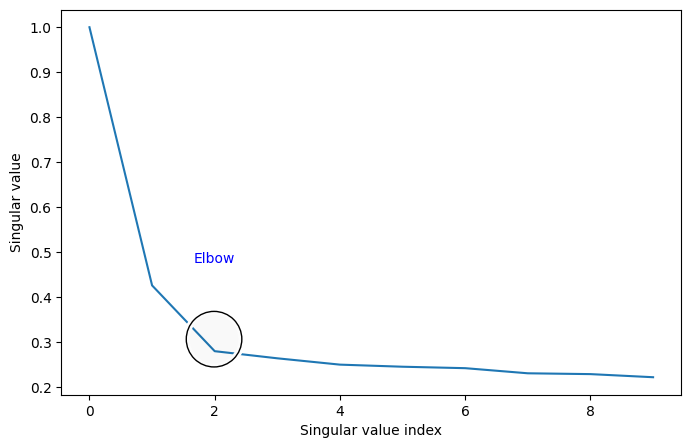

In [9]:
# from graspologic.plot import screeplot
from matplotlib.patches import Circle
from matplotlib.patheffects import withStroke
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredDrawingArea
from scipy.linalg import svdvals

fig, ax = plt.subplots(figsize=(8, 5))

# sv plot
ax.plot(s[:10])
ax.set_xlabel("Singular value index")
ax.set_ylabel("Singular value")

# plot circle
x, y = .15, .15
radius = .15
ada = AnchoredDrawingArea(150, 150, 0, 0, loc='lower left', pad=0., frameon=False)
circle = Circle((105, 35), 20, clip_on=False, zorder=10, linewidth=1,
                edgecolor='black', facecolor=(0, 0, 0, .0125),
                path_effects=[withStroke(linewidth=5, foreground='w')])
ada.da.add_artist(circle)
ax.add_artist(ada)

# add text
def text(x, y, text):
    ax.text(x, y, text, backgroundcolor="white",
            ha='center', va='top', color='blue')
    
text(2, .5, "Elbow")

You'll notice that there's a marked area called the "elbow". This is an area where singular values stop changing in magnitude as much when they get smaller: before the elbow, singular values change rapidly, and after the elbow, singular values barely change at all. (It's called an elbow because the plot kind of looks like an arm, viewed from the side!)

The location of this elbow gives you a rough indication for how many "true" dimensions your latent representation has. The singular values after the elbow are quite close to each other and have singular vectors which are largely noise, and don't tell you very much about your data. It looks from the scree plot that you should be embedding down to two dimensions, as the smaller dimensions tend to be more "noisy" than the first few. The first few will tend to do a good job of describing the overall structure of the matrix that you have embedded, whereas successive dimensions tend to 

One drawback to this method is that a lot of the time, the elbow location is pretty subjective - real data will rarely have a nice, pretty elbow like the one you see above. The advantage is that it still generally works pretty well; embedding into a few more dimensions than you need isn't too bad, since you'll only have a few noise dimensions and there still may be *some* signal there.

In any case, Graspologic automates the process of finding an elbow using a popular method developed in 2000 by Dr. Thomas Minka at MIT (called `minka`, from {cite:p}`Minka2000`). We won't get into the specifics of how it works here, but you can usually find fairly good elbows automatically.

## Identifying the latent representation of the Laplacian

Finally, we get to the exciting part: it's time to actually find this latent representation of the Laplacian. Once you have your number of embedding dimensions, which we'll call $\hat d$ (an *estimate* of the optimal number of embedding dimensions; the $\hat \cdot$ symbol just means estimate, like it did for the MLE), what you're going to do is as follows:
1. Take the first $\hat d$ columns of the left singular vectors matrix, $U$, and put them in a rectangular matrix which is $n \times \hat d$ dimensions. Remember that each left singular vector $\vec u_i$ is $n$-dimensional, so there is one entry for each of the $n$ nodes in the network. The resulting matrix will look like this:
\begin{align*}
    U_{\hat d} &= \begin{bmatrix}
    \uparrow & & \uparrow \\
    \vec u_1 & ... & \vec u_{\hat d} \\
    \downarrow & & \downarrow
    \end{bmatrix}
\end{align*}
2. Take the square roots of the first $\hat d$ singular values from the singular values matrix $\Sigma$, and put them in a diagonal matrix which is $\hat d \times \hat d$ dimensions. The resulting matrix will look like this:
\begin{align*}
    \sqrt{\Sigma_{\hat d}} &= \begin{bmatrix}
        \sqrt{\sigma_1} & 0 & ... & 0 \\
        0 & \sqrt{\sigma_2} & \ddots & \vdots \\
        \vdots & \ddots & \ddots & 0 \\
        0 & ... & 0 & \sqrt{\sigma_{\hat d}}
    \end{bmatrix}
\end{align*}
3. Take the product of $U_{\hat d}$ and $\sqrt{\Sigma_{\hat d}}$, and call this an *estimate* of the latent position matrix $X$. Since this matrix is the product of a $n \times \hat d$ matrix and a $\hat d \times \hat d$ matrix, it will be $n \times \hat d$ as well. The resulting matrix will look like this:
\begin{align*}
    \hat X &= U_{\hat d} \sqrt{\Sigma_{\hat d}} = \begin{bmatrix}
    \uparrow & & \uparrow \\
    \sqrt{\sigma_1} \vec u_1 & ... & \sqrt{\sigma_{\hat d}}\vec u_{\hat d} \\
    \downarrow & & \downarrow
    \end{bmatrix}
\end{align*}

With some assumptions, this *estimate* of a latent position matrix can be shown to be *reasonable*, in that if you were to assume that the network underlying your sample were random and that the assumptions that you learned in {numref}`ch5:rdpg` might be suitable for your network sample, this particular way of finding a latent representation $\hat X$ for your network would serve as a pretty good estimate for the latent position matrix of the corresponding random network. If you are a statistician, we would encourage you to check out the Appendix sections {numref}`app:ch13:spectral` for more details on the justifications and intuition behind spectral embeddings.

So now, let's take a look at how we can visualize the resulting estimate of the latent position matrix, $\hat X$.

(ch5:spectral:heatmap)=
### Heatmaps

The first, and most basic, way to visualize $\hat X$ would be through a heatmap, which you have learned about previously in the context of adjacency matrices. Here, the heatmap will have rows which are the rows of $\hat X$ (there are $n$ of them in total, one for each node), and the columns will be the *estimates of the latent dimensions* $\sqrt{\sigma_k} \vec u_k$. A heatmap of $\hat X$ looks like this:

In [ ]:
from graspologic.embed.svd import select_dimension

# select optimal number of dimensions using minka first elbow
khat = select_dimension(s)[0][0]
# estimate of latent position matrix
Xhat = U[:, 0:(khat + 1)] @ np.diag(s[:(khat + 1)])

In [ ]:
fig, ax = plt.subplots(figsize=(4, 8))
cmap = cmaps["sequential"]
ax = sns.heatmap(Xhat, cmap=cmap, ax=ax, 
                 xticklabels=["Dim. 1", "Dim. 2"])
ax.set_yticks([0, 49, 99])
ax.set_yticklabels(["1", "50", "100"])
ax.set_xlabel("Estimated Latent Dimension")
ax.set_ylabel("Node")

ax.set_title("Estimate of Latent Position Matrix $\\hat X$", fontsize=22, y=1.01)

plt.tight_layout();

What you can see is that the nodes corresponding to the first $50$ students tend to have a high value in estimated latent dimension $2$, and the second $50$ students tend to have a lower value in estimated latent dimension $2$. 

It seems like, using this information, you might even be able to conclude just looking at the heatmap that the students with high values in estimated latent dimension $1$ might have something else in common (hint: they all go to the same school!). This is no random accident: in a network sample which you think can be well-described as a sample from a stochastic block model, you will tend to find that the nodes tend to form these nice, easily identifiable clusters in the estimate of the latent position matrix. However, this pattern is, again, mainly discernable due to the fact that the nodes were given to you already in sorted order. If the nodes had been given to you in random order, what you might see in practice would look something a little more like this:

In [ ]:
reorder_nodes = np.random.permutation(100)
Xhat_reordered = Xhat[reorder_nodes,:]
zs_reordered = zs[reorder_nodes]

In [ ]:
fig, ax = plt.subplots(figsize=(4, 8))
cmap = cmaps["sequential"]
ax = sns.heatmap(Xhat_reordered, cmap=cmap, ax=ax, 
                 xticklabels=["Dim. 1", "Dim. 2"])
ax.set_yticks([])
ax.set_xlabel("Estimated Latent Dimension")
ax.set_ylabel("Node locations unordered")

ax.set_title("$\\hat X$ Reordered", fontsize=22, y=1.01)

plt.tight_layout();

How can you overcome this new hurdle?

(ch5:spectral:pairs)=
### The "Pairs" Plot

From the heatmap you saw above, it seems pretty clear that there is something fishy going on. It looks like the students from school $1$ tend to have a high value in estimated latent dimension $2$, and the In particular, you want to see whether there are any groups of nodes which tend to have similar estimated latent positions. Two particularly useful ways of doing this are through heatmaps (which you learned about above, with the noted limitation) and another approach, known as a "pairs plot". In a pairs plot, you investigate how effectively the embedding "separates" nodes within the dataset into individual "clusters". You will ultimately exploit these "clusters" that appear in the latent positions to predict community assignments for each node in the section on [Community detection](ch7:commdetect). These patterns of networks to have community structure which might not be superficially obvious are called **latent community structure**. Again, here *latent* is just a fancy word which means it's hidden from you when you get the network.

To study the pairs plot, you can simply call the pairs plotting utility directly from `graspologic`:

In [ ]:
from graspologic.plot import pairplot

_ = pairplot(Xhat, title="Pairs plot of randomly reordered $\\hat X$")

As you can see, the pairs plot is a `d x d` matrix of plots, where `d` is the total number of features of the matrix for which a pairs plot is being produced. The plot is called a "pairs" plot because it plots "pairs" of dimensions. 

For each off-diagonal plot (the scatter plots), the $k^{th}$ row and $l^{th}$ column scatter plot has the points $(x_{ik}, x_{il})$ for each node $i$ in the network. Stated another way, the off-diagonal plot is a scatter plot for each node of the $k^{th}$ dimension and the $l^{th}$ dimension of the matrix being plotted. That these scatter plots indicate that the points appear to be separated into individual clusters provides evidence that there might be latent community structure in the network. It is pretty clear that this plot is symmetric, since the off-diagonal entries are simply mirror images of one another (one will be dimension $k$ against dimension $l$, and the off-diagonal entry will be dimension $l$ against dimension $k$).

The diagonal elements of the pairs plot simply represent histograms or density estimates (called *Kernel Density Estimates*, or KDEs) of the estimated latent positions for each dimension. If you do not pass in labels, you obtain histograms, which are just scaled bins which show the number of points for a given dimension which fall into the indicated range. If you do pass in labels, you obtain density estimates, where higher densities indicate that more points have latent position estimates in that range. For instance, the top-left density estimate indicates a density estimate of the first latent dimension for all nodes, the middle is a density estimate of the second latent dimension for all nodes, so on and so forth.

When the number of embedding dimensions is two, showing a full pairs plot is redundant, so you will often simply show a scatter plot of dimension $1$ against dimension $2$.

Now, let's see what happens to the pairs plot for the randomly reordered $\hat X$, which we pass in the reordered school labels for each node, too:

In [ ]:
_ = pairplot(Xhat_reordered, labels=zs_reordered, legend_name = "School",
             title="Pairs plot of randomly reordered $\\hat X$")

Now we're getting somewhere! It looks like there are different "blobs" of latent positions, and each blob corresponds to a single community in the underlying SBM. This will be extremely useful to us in {numref}`ch7:comm_detect` when we attempt to guess the underlying community structure from an SBM.

## Adjacency Spectral Embedding

As it turns out, you can learn a lot about a network without needing to take its Laplacian, too: you could have just spectrally embedded the adjacency matrix alone, and there would be lots of information for you to learn. This process, called adjacency spectral embedding (`ASE`), also produces an estimate of the latent position matrix, $\hat X$.

## What does this have to do with the RDPG?

If you remember back to {numref}`ch5:rdpg`, you learned a lot about Random Dot Product Graphs (RDPGs), which were random networks $\mathbf A$ with $n$-nodes, where you learned that the probability matrix $P = XX^\top$ was the product of the latent position matrix with itself (transposed). As it turns out, the reason that we use the notation $\hat X$ that we do above is that, in essence, if we assume the network that we have is a sample of an RDPG with latent position matrix $X$, then $\hat P = \hat X \hat X^\top$, the product of the estimate of the latent position matrix with itself (transposed), is a good estimate of the probability matrix for the corresponding RDPG, $P$. What we mean by "good" here is that, when the graph is big enough (it has enough nodes), then $\hat P$ will be close to $P$. 

When we say "close" here, if you haven't worked too much with matrices before, this concept might be a little bit strange to you. When you think of "closeness" of vectors, you probably might think of the Euclidean distance:

````{prf:definition} Euclidean distance between two vectors
:label: ch6:se:eucl_dist
If $\vec x = (x_i)_{i = 1}^d$ and $\vec y = (y_i)_{i = 1}^d$ are two $d$-dimensional real vectors, the Euclidean distance is defined:
```{math}
    \|\|\vec x - \vec y\|\|_2 = \sqrt{\sum_{i = 1}^d (x_i - y_i)^2}.
```
````

In a picture where $d=2$, this looks like this:

In [ ]:
from numpy.linalg import norm

x = np.array([1, 6])
y = np.array([4, 2])
distance = norm(x-y, ord=2)

In [ ]:
import pandas as pd
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.quiver([0, 0, y[0]], [0, 0, y[1]], [x[0], y[0], x[0] - y[0]], [x[1], y[1], x[1] - y[1]], angles="xy", scale=1, scale_units="xy", color=sns.color_palette())
plt.xlim(-1, 5)
plt.ylim(-1, 8)
plt.axvline(x=0, color='grey')
plt.axhline(y=0, color='grey')

ax.text(0.2, 3.5, r'$\vec x$', size=15, color=sns.color_palette()[0]);
ax.text(2, .3, r'$\vec y$', size=15, color=sns.color_palette()[1]);
ax.text(3, 4, r'$\vec x - \vec y$', size=15, color=sns.color_palette()[2]);

And the Euclidean distance $||\vec x - \vec y||_2$ simply measures the "length" of this green arrow, giving us an idea of how "far" $\vec x$ and $\vec y$ are apart. In the exact same way, for two matrices $X$ and $Y$, we have the Frobenius distance:

````{prf:definition} Frobenius distance between two matrices
:label: ch6:se:frob_dist
If $X$ and $Y$ are two real-valued matrices with the same number of rows $r$ and columns $c$, the Frobenius distance is defined:
```{math}
    \|\|X - Y\|\|_F = \sqrt{\sum_{i = 1}^r\sum_{j = 1}^c (x_{ij} - y_{ij})^2}.
```
````

So, when we say "close" here, what we mean is that with high probability, $||P - \hat P||_F$ will be small. We discuss this more and show some examples in the Appendix, in {numref}`app:ch13:spectral`.

However, we have a slight issue when we try to interpret $\hat X$ by itself: *non-identifiability*.

(ch6:spectral:nonidentifiable)=
### Spectral embeddings are rotationally non-identifiable

As it turns out, there are many "reasonable" embeddings that can be produced, which will share the same computational niceties as the one you learned about above. In particular, there are *infinitely many* embeddings that are, for all intents and purposes, *identical* up to a rotation. What exactly does this mean? A **rotation matrix** $W$ is a matrix where $WW^\top = I$, the identity matrix. If we remember back to linear algebra, when we multiply a matrix by the identity matrix, we get the original matrix right back.

Let's see what our original latent positions look like as a scatter plot (a plot of $\hat X$ similar to the pairs plot you learned about above), and then when we apply a rotation matrix $W$ to $\hat X$, such as if we rotate $\hat X$ by 90 degrees:

In [ ]:
W = np.array([[0, 1], [1, 0]])
Yhat = Xhat @ W

In [ ]:
import pandas as pd
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

def plot_latents(X, Y, ax=None, title=""):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(8,6))
    dat = pd.DataFrame({"Dimension 1": np.concatenate([X[:,0], Y[:,0]]),
                        "Dimension 2": np.concatenate([X[:,1], Y[:,1]]),
                       "Group": ["est. latent positions" for i in range(0, 100)] + 
                        ["Rotated est. latent positions" for i in range(0, 100)]})
    sns.scatterplot(data=dat, x="Dimension 1", y="Dimension 2", hue="Group", ax=ax)
    return

plot_latents(Xhat, Yhat, ax=ax)

As you can see above, the latent positions are *basically* the same, except they are rotated by $90$ degrees for the rotated points, in orange. This is one particular example of a rotation, but there are infinitely many rotations we could make for our $2$-dimensional latent position matrix.

What if we had a new matrix, $\hat Y = \hat X W$, where $W$ was any one of these possible rotations? Using the rules of matrix multiplication, then:
\begin{align*}
    \hat Y \hat Y^\top &= (\hat X W)(\hat X W)^\top,
\end{align*}
which is because $\hat Y = \hat X W$. Applying the definition of a transpose, we get:
\begin{align*}
    \hat Y \hat Y^\top &= \hat X W W^\top \hat X^\top, \\
    &= \hat X I\hat X^\top,
\end{align*}
which is because $W$ was a rotation matrix, so $WW^\top = I$. Finally, since $XI = X$ (since $I$ is the identity matrix), then:
\begin{align*}
    \hat Y \hat Y^\top &= \hat X \hat X^\top = \hat P,
\end{align*}
giving us that if we assumed $\hat Y$ to *also* be an estimate of the latent position matrix, we would obtain the same estimate of the probability matrix, $\hat P$, as we would if we used $\hat X$.

This problem is referred to **rotational non-identifiability** of the latent position matrix, which means that we can estimate a latent position matrix, but we can only estimate it *up to a rotation*. *Any* of the possible ways we could rotate our estimate of a latent position matrix would, without more information, be *just as good*! Perhaps surprisingly, this isn't really problematic when you spectrally embed a single network. It can, however, become an issue when you try to compare spectral embeddings for different networks or spectrally embed a bunch of networks simultaneously. You'll learn more about this problem, and some work-arounds to it, in later sections, including {numref}`ch6:multinet` and {numref}`ch8:twosample`.

## Using Graspologic to embed networks

It's pretty straightforward to use graspologic's API to embed a network. The setup works like an SKlearn class: you instantiate an `AdjacencySpectralEmbed` class, and then you use it to transform data. We can set the number of dimensions to embed to (the number of singular vector columns to keep!) with `n_components`, or alternatively, let this value be selected automatically with elbow selection. We'll show how to use adjacency spectral embedding where you let elbow selection do the work picking the number of dimensions for you, and Laplacian spectral embedding where you know the right number of dimensions to embed with is $2$.

For the example, we'll start with the adjacency matrix for the network you studied above, but randomly reorder the nodes, like this:

In [ ]:
A_reordered = A[reorder_nodes,:][:,reorder_nodes]

In [ ]:
draw_multiplot(A_reordered, title="A with nodes randomly reordered");

We then embed the reordered adjacency matrix, using either adjacency spectral embedding or Laplacian spectral embedding.

### Adjacency Spectral Embedding

When you don't specify `n_components` ahead of time, elbow selection is performed automatically:

In [ ]:
from graspologic.embed import AdjacencySpectralEmbed as ASE
# Instantiate an ASE model and find the embedding
ase = ASE()
embedding = ase.fit_transform(A_reordered)

In [ ]:
print("Estimated number of latent dimensions: {:d}".format(ase.n_components_))

_ = pairplot(embedding, title="Adjacency Spectral Embedding pairs plot");

### Laplacian Spectral Embedding

Here, we'll specify ahead of time `n_components=2`, and embed into two dimensions:

In [ ]:
from graspologic.embed import LaplacianSpectralEmbed as LSE

lse = LSE(n_components=2)
embedding = lse.fit_transform(A_reordered)

In [ ]:
_ = pairplot(embedding, title="Laplacian Spectral Embedding pairs plot");

In both cases, we can see that we have two pretty easily discernable blobs in the estimates of the latent positions. These blobs will be useful when we try to learn community assignments for the nodes in {numref}`ch7:comm_detect`. 

## Want more linear algebra?

Now that's a question that is rarely asked! For network embeddings, however, if you have a more robust mathematical background, we would encourage you to check out the appendix sections for the results we have here. They can be found in {numref}`app:ch13:spectral`. While a bit more cumbersome mathematically, we think that some of this mathematical burden goes a long way to reinforcing the intuition of the processes and approaches chosen. The appendix reflects a brief overview of the survey paper {cite:p}`Athreya2017Jan` as they concern this book.

## References

```{bibliography}
:filter: docname in docnames
:style: unsrt
```